In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter("ignore") #suppressing warnings use: warnings.resetwarnings() to reset back to default
#warnings.resetwarnings()

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_percentage_error

from scipy.stats import ttest_ind

import pmdarima as pm

from datahelper import *
import startup_config_preferences
import pickle
import os
import jinja2

from openpyxl.styles import PatternFill, Alignment, Border, Side, Font

# Classes and Functions

In [159]:
class GrangerHelper:
    def __init__(self, df, fcol, input_values = None, target_descriptions = None):
        self.df = df.copy()
        self.fcol = fcol
        values = -1*df.Debit if input_values is None else input_values
        
        if not hasattr(self, "max_lag") or not hasattr(self, "time_col"):
            raise NotImplementedError("GrangerHelper is an abstract class, time_col and max_lag must be called from derived classes")
        
        if target_descriptions is None:
            self.df_crosstab = self.get_crosstab(values)
        else:
            self.df_crosstab = self.get_crosstab(values, GrangerHelper.outer_query(df, "Description", target_descriptions, "txn_amt"))

        self.results = GrangerHelper.granger_causality(self.df_crosstab, self.max_lag, self.fcol)

        txn_sums = self.df.groupby(["fyear", "Period"]).txn_amt.sum()
        df_peaks = ((txn_sums > txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("peaks").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("troughs").to_frame())
        df_trends = ((txn_sums > txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("downward").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("upward").to_frame())
        self.df_trends = self.df.groupby(["fyear", "Period", "desc1", "Account"]).txn_amt.sum().unstack("Account").join(df_peaks.join(df_trends).idxmax(axis = 1).rename("trends"))
        
    def set_scale (df, col):
        return df.copy().eval(f"{col} = ({col} - {col}.mean())/{col}.std()")

    def get_crosstab(self, value_col = 'txn_amt', target_col = 'txn_amt'):
        times = self.df[self.time_col] if type(self.time_col) == str else self.time_col
        features = self.df[self.fcol] if type(self.fcol) == str else self.fcol
        values = self.df[value_col] if type(value_col) == str else value_col
        targets = self.df[target_col] if type(target_col) == str else target_col

        return self.make_stationary(pd.crosstab(times, 
                            features,
                            values = values, 
                            aggfunc = "sum"
                        )
                    .fillna(0)
                    .join(targets.groupby(times).sum())
                )

    def granger_causality(df_crosstab, max_lag, fcol):
        df_checklag = df_crosstab[df_crosstab.columns[~(df_crosstab.take(range(max_lag, df_crosstab.shape[0]-max_lag)).sum() == 0)]].drop("txn_amt", axis = 1)

        feature_list = []

        for feature in df_checklag.columns.unique():
            #print(feature)
            results = grangercausalitytests(df_crosstab[["txn_amt", feature]], maxlag = max_lag, verbose = 0)
            
            for i in range(1, len(results)+1):
                feature_list.append([feature, i, min([t[1] for t in results[i][0].values()])])

        return pd.DataFrame(feature_list, columns = [fcol, "lag", "pvalue"]).query("pvalue < 0.05").sort_values("pvalue", ascending = False)

    def outer_query(df, query_col, query_target, val_col):
        if type(query_target) == str:
            condition = df[query_col] == query_target
        else:
            condition = df[query_col].apply(lambda x: x in query_target)

        return ((condition).astype(int)*df[val_col]).rename(val_col)
    
    def get_time_col(self):
        return self.time_col
    
    def plot_lags(self, lags = None, xlim = None):
        plt.figure(figsize = (18,10))
        lags_list = []

        if lags is None:
            col_names = self.df_crosstab.columns
            df_all_desc1_lags = pd.concat([self.df_crosstab.shift(i).set_axis(col_names + "_" + str(i), axis = 1) for i in range(1, 6)], axis = 1).fillna(0) #This is exploding the crosstab table to consider all possible lags
            selected_desc1_lag_cols = self.results.apply(lambda x: x.desc1 + '_' + str(x.lag), axis = 1).values.tolist()
            x1 = df_all_desc1_lags[selected_desc1_lag_cols].sum(axis = 1).to_frame(name = "debit_amt").pipe(GrangerHelper.set_scale, "debit_amt")
            lags_list.append(x1)
            plt.plot(x1, label = x1.columns[0])
        else:
            if type(lags) == int:
                lags = [lags]
            
            for lag in lags:
                lag_features = self.results.query(f"lag == {lag}")[self.fcol].unique().tolist()
                x1 = self.df_crosstab[lag_features].sum(axis = 1).rename("txn_amt").shift(lag).to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt": f"debit_amt_lag{lag}"})
                lags_list.append(x1)
                plt.plot(x1, label = x1.columns[0])

        x2 = self.df_crosstab.txn_amt.to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt":"target_txn_amt_total"})
        x3 = self.df.groupby(self.time_col).txn_amt.sum().rename("txn_amt_total").to_frame().pipe(GrangerHelper.set_scale, "txn_amt_total")
        if x2.shape[0] != x3.shape[0] or (x2.values != x3.values).any():
            plt.plot(x2, label = x2.columns[0], alpha = 0.8, linestyle = "dotted")

        stepsize = 2 if x2.shape[0] < 50 else 7
        # print(len(x2.index[::stepsize]))
        # print(len(self.xtick_labels()[::stepsize]))
        plt.plot(x3, label = x3.columns[0], alpha = 0.7, linestyle = "dashed")
        plt.xticks(ticks = x2.index[::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)

        if xlim is not None:
            plt.xlim(xlim)

        plt.legend()
        return pd.concat(lags_list + [x2], axis = 1)

    def lag_stats(self, lags = 2, trough_time_idx = 41):

        if type(lags) == int:
            lags = [lags]

        if type(trough_time_idx) == int:
            trough_time_idx = [trough_time_idx]
        
        lag_trough_idx = {}

        for l in lags:
            for t in trough_time_idx:
                if t - l not in lag_trough_idx:
                    lag_trough_idx[t-l] = []
                lag_trough_idx[t-l].append(l)

        lag_features = self.results.query(f"lag in {lags}")[self.fcol].unique().tolist()
        df_lag_features = self.df.query(f"{self.fcol} in {lag_features} and {self.time_col} in {list(lag_trough_idx.keys())}")
        #time_lag_descriptions = df_lag_features.Description.unique()
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        self.df_lag_features = df_lag_features

        return (df_lag_features
                    .groupby(["desc1", self.time_col])
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax()[0], x.name, x.max(), x.idxmax()[1]))
                    .T
                    .set_axis(["desc1", "metric", "value", self.time_col], axis = 1)
                    .reset_index(drop = True)
                    .assign(lag = lambda x: x[self.time_col].map(lag_trough_idx))
        )
    
    def plot_desc1_summary(self, desc1):
        #stepsize = 2 if self.df_crosstab.shape[0] < 50 else 7

        self.df.query(f"desc1 == '{desc1}'").pivot_table(columns = self.fcol, index = self.time_col, values = "txn_amt", aggfunc = "sum").plot(figsize = (18,10), linestyle = "dashed", alpha = 0.6)
        plt.plot(self.df.groupby(self.time_col).txn_amt.sum().to_frame(), label = "all", color = "red")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "all")
        plt.plot(self.df.query(f"desc1 == '{desc1}'").groupby(self.time_col).txn_amt.sum().to_frame(), label = desc1, color = "blue")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "001256")
        
        #plt.xticks(ticks = self.df_crosstab.index[1::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)
        plt.legend()
    
    def lag_ols(df_results):
        GLDataHelper(df_results, "target_txn_amt_total").run_pipeline(["ols"])["model"].summary()

    def xtick_labels(self):
        raise NotImplementedError
    
    def make_stationary(self, df):
        return df


class PFYGrangerHelper(GrangerHelper):
    time_col = "period_fyear"
    max_lag = 5
    period_month_mapper = [" ", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"]

    def xtick_labels(self):
        return (self.df[["Period", "fyear", "period_fyear"]]
                    .query("period_fyear in @self.df_crosstab.index")
                    .drop_duplicates()
                    .apply(lambda x: self.period_month_mapper[x.Period] + " FY" + str(x.fyear)[-2:] + " (" + str(x.period_fyear) + ")", axis = 1)
                    .tolist()
                )
    
    def make_stationary(self, df):
        return df.diff().dropna()
    
    def lag_stats(self, lag = 1, trough_time_idx = 40):
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        lag_features = self.results.query(f"lag == {lag}").desc1.tolist()
        query_condition = f"period_fyear == {trough_time_idx} - {lag} or period_fyear == {trough_time_idx} - {lag} - 1"
        min_diff_desc1 = (self.df
                            .query(f"desc1 in {lag_features}")
                            .query(query_condition)
                            .pivot_table(index = "period_fyear", columns = "desc1", values = "txn_amt", aggfunc = "sum")
                            .set_axis(["period1", "period2"])
                            .T
                            .eval("period_diff = period2 - period1")
                            .idxmin()
                            .period_diff
                            )
        df_lag_features = (self.df
                            .query(f"desc1 == '{min_diff_desc1}'")
                            .query(query_condition)
                        )

        return (df_lag_features.groupby("Description")
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax(), x.name, x.max()))
                    .T
                    .set_axis(["Description", "metric", "value"], axis = 1)
                    .reset_index(drop = True)
                    .eval(f"time_col = '{self.time_col}'")
                    .eval(f"lag = {lag}")
                    .eval(f"trough_time_idx = {trough_time_idx}"),
                    df_lag_features.Description.unique()
                )
        
class WFYGrangerHelper(GrangerHelper):
    time_col = "week_fyear"
    max_lag = 21

    def xtick_labels(self):
        return (self.df[["Date", "week", "fyear", "week_fyear"]]
                    .groupby("week_fyear")
                    .Date
                    .min()
                    .dt
                    .strftime("%m/%d/%y")
                    .reset_index()
                    .apply(lambda x: x.Date + " (" + str(x.week_fyear) + ")", axis = 1)
                    .tolist()
                )
    def get_week_fyears(self, Period, fyear):
        return self.df.query(f"Period == {Period} and fyear == {fyear}").week_fyear.unique()

    def get_period_fyear(self, week_fyear):
        return (self.df.query(f"week_fyear == {week_fyear}").Period.unique()[0],
                self.df.query(f"week_fyear == {week_fyear}").fyear.unique()[0]
                )
    
    def get_period_by_year(self, week_fyear):
        week = self.df.query("week_fyear == @week_fyear").week.unique()[0]
        return self.df.query("week == @week").groupby("fyear").apply(lambda x: x.Period.unique()[0])

    def lag_stats(self, lags = 2, trough_time_idx = 41, trough_idx = None, normalize = False):
        lag_table = super().lag_stats(lags, trough_time_idx)

        lag_table = (lag_table
                .assign(Period = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[0]))
                .assign(fyear = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[1]))
        )
        desc1_list = lag_table.desc1.tolist()
        week_fyear_list = lag_table.week_fyear.tolist()
    
        display(lag_table)
        
        df_trends = self.df_trends

        if normalize:
            df_trends = (self.df_trends
                            .drop("trends", axis = 1)
                            .groupby(["fyear", "Period"], as_index = False)
                            .apply(lambda df: df.apply(lambda x: x/x.sum()))
                            .reset_index(level = 0, drop = True)
                            .join(self.df_trends.trends)
                        )
        
        desc1_table_dict = {}

        for wfy,desc1 in zip(week_fyear_list, desc1_list):
            period_table = self.get_period_by_year(wfy).reset_index(name = "Period").merge(df_trends.reset_index(), on = ["Period", "fyear"])
            
            if trough_idx is not None:
                period_table = pd.concat([period_table, df_trends.query("Period == @trough_idx").reset_index()], axis = 0).set_index(["Period", "fyear", "desc1"]).unstack("Period")
            
            # desc_dict[(desc1, wfy)] = self.df.query("desc1 == @desc1 and week_fyear == @wfy").sort_values(ascending = False, by = "txn_amt").Description.head(5).tolist()
            desc1_table_dict[(desc1, wfy)] = period_table.query("desc1 == @desc1").dropna(axis = 1, how = "all")
            desc1_table_dict[(desc1, wfy)] = pd.concat([
                                                            desc1_table_dict[(desc1, wfy)].filter(regex = "Acct").fillna(0),
                                                            desc1_table_dict[(desc1, wfy)].filter(regex = "trends").fillna(" -- ")
                                                        ], axis = 1).round(2)
    
            display(
                        (desc1, wfy),
                        desc1_table_dict[(desc1, wfy)]
            )
        
        return lag_table, desc1_table_dict

In [550]:
#PatternFill openpyxl reference for working with styles: https://openpyxl.readthedocs.io/en/stable/styles.html
#Color Picker URL: https://redketchup.io/color-picker

def write_or_append_to_excel(df, filename, sheetname, title):
    edit_mode_var, if_sheet_exists = ("a", "replace") if os.path.isfile(filename) else ("w", None)
    
    with pd.ExcelWriter(filename, mode = edit_mode_var, if_sheet_exists = if_sheet_exists) as writer:
        df.to_excel(writer, sheet_name = sheetname, startcol = 1, startrow = 1, engine = "openpyxl")

        #workbook = writer.book
        worksheet = writer.sheets[sheetname]

        green_header = PatternFill(start_color='FF70AD47', fill_type = "solid")
        alignment = Alignment(horizontal="center", 
                              vertical = "center"
                            )
        thick_border_side = Side(border_style="thick", color = "000000")
        thin_border_side = Side(border_style="thin", color = "000000")

        #Defining Input Table Shape Variables
        nrows = df.index.shape[0]
        ncolumns = df.columns.shape[0]

        #Defining Table Variables
        table_row_start = 2
        table_row_end = table_row_start + df.columns.nlevels + nrows
        table_col_start = 2
        table_col_end = table_col_start + ncolumns

        #Defining Table Body Variables
        body_col_start = table_col_start+1
        body_row_start = table_row_start+df.columns.nlevels

        #Define Iterables
        table_header_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = body_row_start-1, min_col = table_col_start, max_col = table_col_end) for cell in row]
        table_idx_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = table_row_end, min_col = table_col_start, max_col = table_col_start) for cell in row]
        body_iter = [cell for row in worksheet.iter_cols(min_row = body_row_start, max_row = table_row_end, min_col = body_col_start, max_col = table_col_end) for cell in row]

        #Delete Exported Row
        worksheet.delete_rows(df.columns.nlevels+2)
        #

        #Edit Title
        worksheet.merge_cells("B1:M1")

        worksheet["B1"].value = title
        worksheet["B1"].font = Font(
                                        bold = True,
                                        size = 20
                                    )
        worksheet["B1"].alignment = alignment
        worksheet.row_dimensions[1].height = 50
        #

        # Editing Column Headers
        for cell in table_header_iter:
            cell.fill = green_header
            cell.alignment = alignment

            if cell.row == table_row_start:
                if cell.value:
                    cell.value = cell.value.title()

                cell.font = Font(
                                    size = 14,
                                    bold = True
                                )
                
            #Add Thick Horizontal Header Border
            if cell.row == body_row_start - 1:
                cell.border =  Border(
                                        top = cell.border.top,
                                        left = cell.border.left,
                                        right = cell.border.right,
                                        bottom = thick_border_side
                                    )
        #

        #Edit Index
        for cell in table_idx_iter:
            cell.fill = green_header
            cell.border = Border(
                                    top = cell.border.top,
                                    left = cell.border.left,
                                    right = thick_border_side,
                                    bottom = cell.border.bottom
                                )
            cell.alignment = alignment
            worksheet.row_dimensions[cell.row].height = 25
        #

        #Edit Table Body: 
        for cell in body_iter:
            cell.number_format = "0.00"
            cell.border = Border(
                                    top = cell.border.top,
                                    left = thin_border_side,
                                    right = thin_border_side,
                                    bottom = thin_border_side
                                )
            cell.fill = PatternFill(start_color='FFEBF1E9', fill_type = "solid")
            cell.alignment = alignment

            if cell.row == body_row_start:
                worksheet.column_dimensions[cell.column_letter].width = 12
        #
            
###########################      
        # for cell in np.array(worksheet["B2:M7"]).ravel():
        #     cell.alignment = alignment

        #Edit Cell Dimensions
        

        # for i in range(2,8):
        #     worksheet.row_dimensions[i].height = 25
        
        # for cell in worksheet["C4:M4"][0]:
        #     worksheet.column_dimensions[cell.column_letter].width = 12
        #

#TODO: March 20 Customize function to take in tables of any dimension  

# Global Variables

In [10]:
df_sales = pd.read_csv("data/df_sales_public.csv", index_col = 0, parse_dates = [5])
df_sales.desc1 = df_sales.desc1.fillna("NA")
dh = GLDataHelper(df_sales, "txn_amt")

In [11]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")

In [12]:
TOP3_DESC1_LIST = ["CB", "EM", "BK"]

# Testing

## Stationarity

### Period_fyear

In [ ]:
adfuller(dh.df.groupby("period_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1]
#NOTE: transactions accross period_fyears is not stationary (p-value > 0.05)

0.0991463267377749

In [6]:
adfuller(dh.df.groupby("period_fyear").txn_amt.sum().diff().dropna(), autolag = "AIC", regression = "ct")[1]
#NOTE: with d = 1, transactions accross period_fyears are now stationary (p-value < 0.05)

2.5166690851529662e-05

### Week_fyear

In [7]:
adfuller(dh.df.groupby("week_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1]
#NOTE: transactions accross week_fyears is stationary (p-value < 0.05)

6.024825051705332e-06

## Two Sample Ttesting (Top 3 desc1s)

In [25]:
s_top_3_desc1s = dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("all")
s_no_BK = dh.df.query("desc1 in ['CB', 'EM']").groupby("period_fyear").txn_amt.sum().rename("no_BK")
s_no_EM = dh.df.query("desc1 in ['CB', 'BK']").groupby("period_fyear").txn_amt.sum().rename("no_EM")
s_no_CB = dh.df.query("desc1 in ['EM', 'BK']").groupby("period_fyear").txn_amt.sum().rename("no_CB")

df_top_3_desc1s = (dh.df
                        .query("desc1 in @TOP3_DESC1_LIST")
                        .groupby(["period_fyear", "desc1"]).txn_amt.sum()
                        .reset_index()
                        .groupby("desc1").txn_amt.std()
                        .sort_values(ascending = False)
                )

print("ttest")
print('-'*12)
pd.concat([s_no_EM, s_no_BK, s_no_CB], axis = 1).fillna(0).apply(lambda x: ttest_ind(x, s_top_3_desc1s)[1])

ttest
------------


no_EM   0.43
no_BK   0.05
no_CB   0.00
dtype: float64

## Granger Causality

In [ ]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")
lag_table, desc1_table_dict = gh_wfy_account.lag_stats(lags = [3,5], trough_time_idx = gh_wfy_account.get_week_fyears(5, 2023), trough_idx = 5, normalize = True)

In [551]:
#Pandas dataframe styling reference url: https://medium.com/@romina.elena.mendez/transform-your-pandas-dataframes-styles-colors-and-emojis-bf938d6e98a2
#More exporting references for excel format exports: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Export-to-Excel

(desc1_table_dict[('CB', 172)]
 .reset_index("desc1", drop = True)
 .pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Desc1 CB, week_fyear 172", "Desc1 CB Comparison Table for Periods 4 and 5")
)


In [497]:
desc1_table_dict[('CB', 172)].reset_index("desc1", drop = True).index.shape[0] + desc1_table_dict[('CB', 172)].reset_index("desc1", drop = True).columns.nlevels

6

In [482]:
lag_table.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Desc1 Lag Table for Period 5 and FY23", "Desc1 Lag Table for Period 5 and FY23")

# Modelling

## ARIMA

In [ ]:
# total_ts = dh.df.groupby("period_fyear").txn_amt.sum()
# seasonal_decompose(dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Transaction)"), period = 12).plot()
# seasonal_decompose((dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum()/total_ts).rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Percentage)"), period = 12).plot()
# seasonal_decompose(dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum()[12:].rename("Top 3 Desc1s Seasonal Decomposition\n(Past 3 years by Transaction)"), period = 12).plot()
# seasonal_decompose((dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum()/total_ts)[12:].rename("Top 3 Desc1s Seasonal Decomposition\n(Past 3 years by Percentage)"), period = 12).plot();

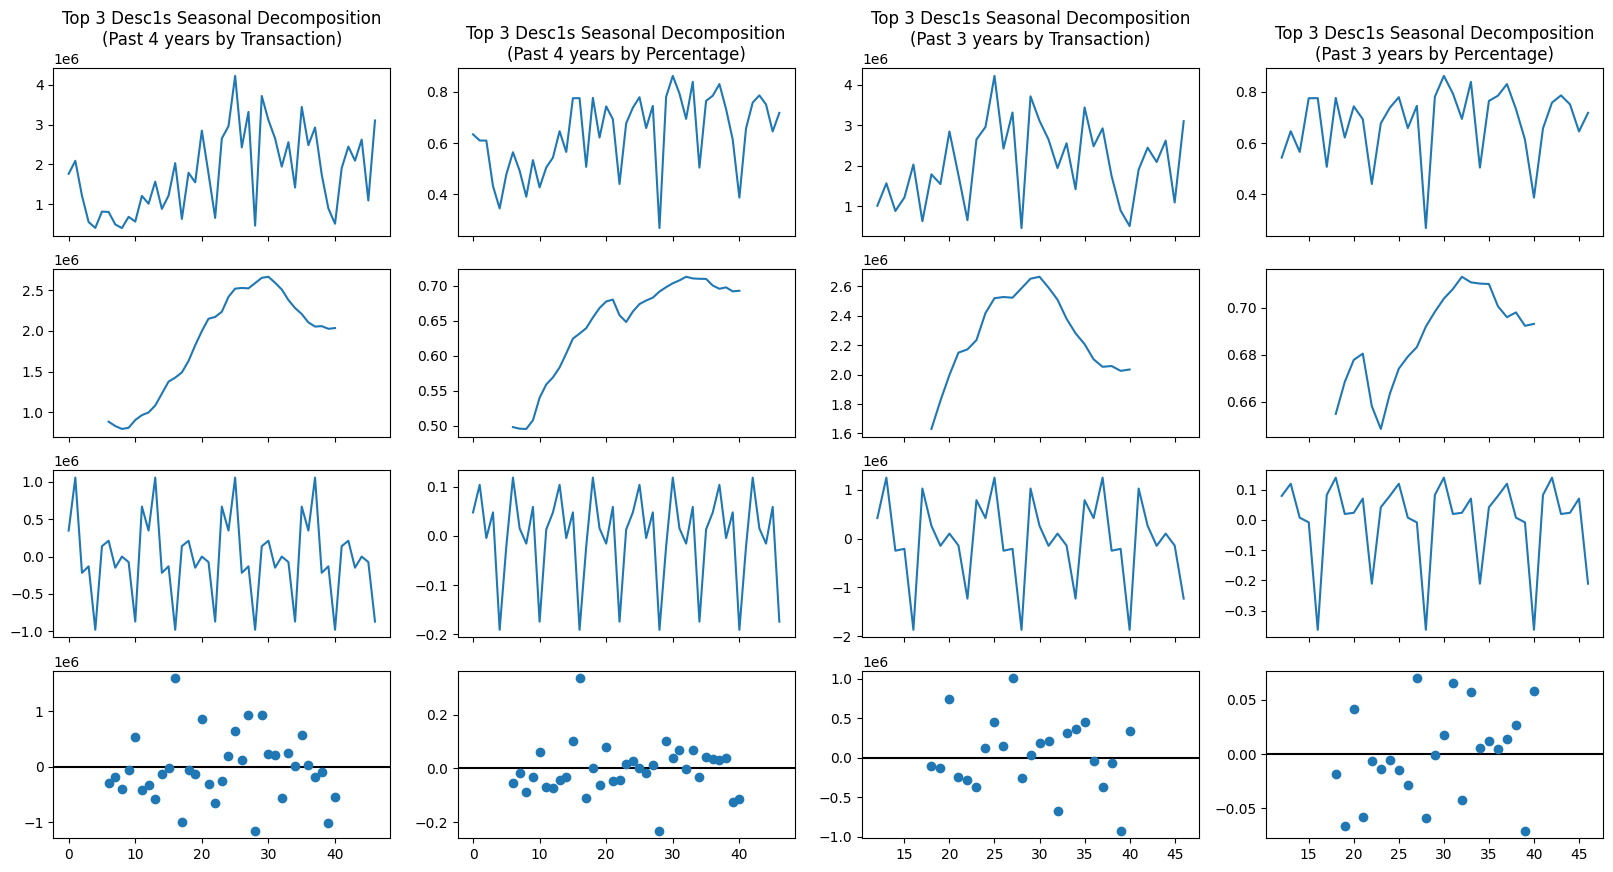

In [80]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, sharex = "col", figsize = (20,10))

total_ts = dh.df.groupby("period_fyear").txn_amt.sum()

df_plot1 = dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Transaction)")
df_plot2 = (df_plot1/total_ts).rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Percentage)")
df_plot3 = df_plot1[12:].rename("Top 3 Desc1s Seasonal Decomposition\n(Past 3 years by Transaction)")
df_plot4 = (df_plot1/total_ts)[12:].rename("Top 3 Desc1s Seasonal Decomposition\n(Past 3 years by Percentage)")

for col, df in enumerate([df_plot1, df_plot2, df_plot3, df_plot4]):
    seasonal_decomp = seasonal_decompose(df, period = 12)
    axs[0,col].plot(df)
    axs[0,col].set_title(df.name)
    axs[1,col].plot(seasonal_decomp.trend)
    axs[2,col].plot(seasonal_decomp.seasonal)
    axs[3,col].axhline(y = 0, color = "black", zorder = 1)
    axs[3,col].scatter(x = seasonal_decomp.resid.index, y = seasonal_decomp.resid, zorder = 2)

best_ts = df_plot4

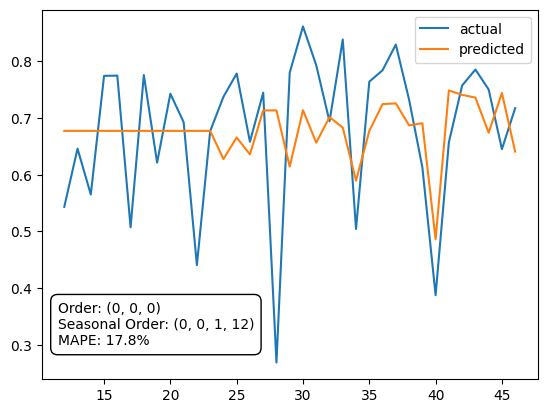

In [102]:
def run_arima(ts, m_freq = 12, plot = False):
    s_model = pm.auto_arima(y = ts, seasonal = True, max_P = 4, max_D = 2, max_Q = 4, test = "adf", m = m_freq, stepwise = True, maxiter = 100)
    pred_ts = pd.Series(s_model.predict_in_sample().values, index = ts.index)
    mape = mean_absolute_percentage_error(y_pred = pred_ts, y_true = ts)
    if plot:
        plt.plot(ts,label = "actual")
        plt.plot(pred_ts, label = "predicted")
        # plt.annotate(f"Order: {s_model.get_params()['order']}\nSeasonal Order: {s_model.get_params()['seasonal_order']}\nMAPE: {round(mape*100, 1)}%", xy = (11.5, 0.3), bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white"))
        plt.legend()
    return s_model, mape

s_model_best, mape_best = run_arima(best_ts, plot = True)
plt.annotate(
                f"Order: {s_model_best.get_params()['order']}\nSeasonal Order: {s_model_best.get_params()['seasonal_order']}\nMAPE: {round(mape_best*100, 1)}%", 
                xy = (11.5, 0.3), 
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            );

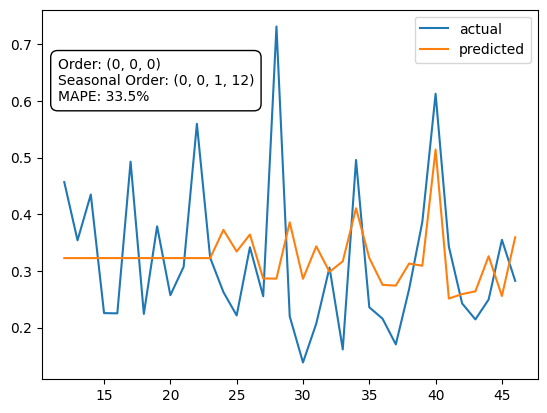

In [103]:
other_ts = (dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Transaction)")/total_ts)[12:]
s_model_other, mape_other = run_arima(other_ts, plot = True)
plt.annotate(
                f"Order: {s_model_other.get_params()['order']}\nSeasonal Order: {s_model_other.get_params()['seasonal_order']}\nMAPE: {round(mape_other*100, 1)}%",
                xy = (11.5, 0.6),
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            );